Análise do dia 28/03 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import CountVectorizer

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Preparação dos dados

In [2]:
# import dos dados

df = pd.read_csv('2803_preprocessado.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [4]:
# aplica função em todos os tokens

df['token3'] = df['token3'].apply(lambda x: strip_characters(x))
df['token3'] = df['token3'].apply(lambda x: str(x).split(' '))

In [5]:
texto = list(df.token3)

# Modelagem

In [6]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [7]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [8]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [10:32<00:00, 45.18s/it]


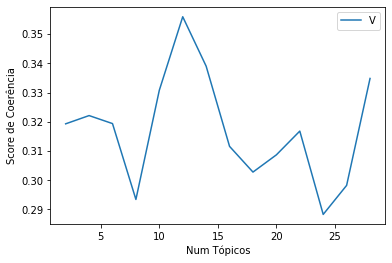

In [10]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [11]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3193
A quantidade de tópicos = 4  tem um valor de coerência de  0.3221
A quantidade de tópicos = 6  tem um valor de coerência de  0.3194
A quantidade de tópicos = 8  tem um valor de coerência de  0.2934
A quantidade de tópicos = 10  tem um valor de coerência de  0.3308
A quantidade de tópicos = 12  tem um valor de coerência de  0.3559
A quantidade de tópicos = 14  tem um valor de coerência de  0.339
A quantidade de tópicos = 16  tem um valor de coerência de  0.3116
A quantidade de tópicos = 18  tem um valor de coerência de  0.3028
A quantidade de tópicos = 20  tem um valor de coerência de  0.3087
A quantidade de tópicos = 22  tem um valor de coerência de  0.3168
A quantidade de tópicos = 24  tem um valor de coerência de  0.2883
A quantidade de tópicos = 26  tem um valor de coerência de  0.2982
A quantidade de tópicos = 28  tem um valor de coerência de  0.3348


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [12]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=3, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

In [13]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -7.078357685190944


In [14]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=texto, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.3644836708584007


In [15]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.112618 -0.367123       1        1  36.260403
1     -0.378245  0.087243       2        1  33.361538
2      0.265627  0.279880       3        1  30.378065, topic_info=           Term          Freq         Total Category  logprob  loglift
53    bolsonaro  16237.000000  16237.000000  Default  30.0000  30.0000
16               13971.000000  13971.000000  Default  29.0000  29.0000
7    presidente  13643.000000  13643.000000  Default  28.0000  28.0000
50         casa  10518.000000  10518.000000  Default  27.0000  27.0000
71       quando   7762.000000   7762.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
102       amigo   1003.888184   1004.550415   Topic3  -5.3570   1.1908
49         cada   1394.146851   1425.737305   Topic3  -5.0286   1.1690
63         vida   2776.011475   3056.650391   Topic3  -4.3399   1.0951
73         qual   1282.585938   1345.165649   Topic3  -5.1120   1.1438
288         fim   1672.074829   1907.607910   Topic3  -4.8469   1.0597

[128 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
16        3  0.999946         
37        2  0.999958   acabar
291       2  0.999900    agora
154       3  0.999703   alguem
102       3  0.999452    amigo
...     ...       ...      ...
63        1  0.091604     vida
63        3  0.908184     vida
538       3  0.999360    video
404       2  0.999351   voltar
74        3  0.999381  vontade

[103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [16]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=4, step=2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:51<00:00, 51.72s/it]


In [18]:
# Escolhe o modelo

optimal_model = model_list[0]
optimal_model.print_topics(num_topics = 3, num_words = 20)

[(0,
  '0.022*"casa" + 0.020*"pandemia" + 0.017*"muito" + 0.016*"presidente" + 0.011*"mundo" + 0.010*"vida" + 0.010*"deus" + 0.009*"nem" + 0.009*"ir" + 0.009*"passar" + 0.008*"bom" + 0.008*"sim" + 0.008*"novo" + 0.007*"logo" + 0.007*"tambem" + 0.007*"gente" + 0.007*"semana" + 0.007*"familia" + 0.006*"nada" + 0.006*"vez"'),
 (1,
  '0.052*"bolsonaro" + 0.033*"presidente" + 0.025*"quando" + 0.023*"acabar" + 0.020*"brasil" + 0.018*"depois" + 0.012*"gente" + 0.012*"sair" + 0.011*"coisa" + 0.010*"contra" + 0.010*"casa" + 0.010*"nem" + 0.010*"saude" + 0.008*"governo" + 0.008*"melhor" + 0.008*"agora" + 0.006*"povo" + 0.006*"nada" + 0.005*"ministro" + 0.005*"mandetta"'),
 (2,
  '0.084*"" + 0.022*"agora" + 0.016*"mae" + 0.014*"casa" + 0.013*"cabelo" + 0.010*"pegar" + 0.009*"gente" + 0.008*"vontade" + 0.008*"tomar" + 0.008*"tava" + 0.007*"comer" + 0.007*"pandemia" + 0.007*"mal" + 0.005*"cu" + 0.005*"porque" + 0.005*"quase" + 0.005*"fim" + 0.005*"foto" + 0.005*"nada" + 0.005*"mundo"')]

In [19]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texto):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [20]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texto)

In [21]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9530,"casa, pandemia, muito, presidente, mundo, vida...","[vida, anitta, sempre, muito, base, passar, im..."
1,1.0,0.9609,"bolsonaro, presidente, quando, acabar, brasil,...","[sair, candidato, voto, deus, concorrer, brasi..."
2,2.0,0.9510,", agora, mae, casa, cabelo, pegar, gente, vont...","[mesa, online, corte, mudar, construir, progre..."


In [23]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,1.0,"bolsonaro, presidente, quando, acabar, brasil,...",56627.0,0.3217
1.0,1.0,"bolsonaro, presidente, quando, acabar, brasil,...",65690.0,0.3732
2.0,1.0,"bolsonaro, presidente, quando, acabar, brasil,...",53722.0,0.3052
3.0,0.0,"casa, pandemia, muito, presidente, mundo, vida...",NaN,NaN
4.0,2.0,", agora, mae, casa, cabelo, pegar, gente, vont...",NaN,NaN
...,...,...,...,...
176034.0,0.0,"casa, pandemia, muito, presidente, mundo, vida...",NaN,NaN
176035.0,0.0,"casa, pandemia, muito, presidente, mundo, vida...",NaN,NaN
176036.0,1.0,"bolsonaro, presidente, quando, acabar, brasil,...",NaN,NaN
176037.0,2.0,", agora, mae, casa, cabelo, pegar, gente, vont...",NaN,NaN


In [24]:
# Criando stopwords em português utilizando a biblioteca nltk
import pt_core_news_sm
nlp = pt_core_news_sm.load()
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior',
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'tem', 'as', 'mas','ao'
                    'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkk','kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'obg',
                    'corona','virus','coronavirus','covid','covid19','19'
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda',
                    'vir', 'bem','ao','sem','ou','vai', 'dizer', 'entao', 'dizer', 'entao',
                    'tao', 'tu', 'mim', 'mano', 'oq', 'pos', 'dm', 'dps',
                    'coronavirusoutbreak', 'coronavirusPandemic', 'dar', 'vairus',
                    'ainda', 'assim']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

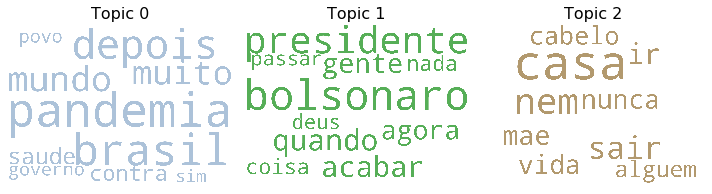

In [25]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [26]:
sent_topics_sorteddf_mallet.to_excel('keywords_0328.xlsx')